# Pre-content: Planning

- Reference and do not repeat on: [Friedrich's ed stuff](https://github.com/ooi-data-review/2018-data-workshops/blob/master/physics/examples/Example%2002%20-%20Using%20the%20OOI%20API%20with%20Python.ipynb)
- Take a look at [Keenan's work](https://github.com/cormorack/notebooks/blob/master/dev_notebooks/keenan/DO%20vs.%20Temperature%20vs.%20Nitrate.ipynb)
as well with Don
- Bridge back to portal: Recreate this chart
- App mode available? Turns the code on/off; is this part of JupyterLab
- Affirmation: Having the code present is a key element of 'feasibility argument'
- Time series chlorophyll as complementary courtesy NASA/CMR: Profiler let's us translate that down thru 200 meters
- Technical challenge: Data presistence/volume. Address by May 30; possibly with some zarr 
- Gallery to cormorack org; work in a dev branch
- Start communication strategy
- More in situo: gliders, surface stations, tethered; again with emphasis on chlorophyll
- Teaching 'resolve separately timed observations' is very endorsed as super valuable
- Looking for guidance in terms of what we want to see
- Susan (instructor for OCNG-200 physical ocng course) to get feedback
- Hunter: can use accordion windows to hide code
- Might be good to get Friedrich’s feedback given previous education experience
- Needed here:
  - MODIS Chlor-A
  - whale call at top on Play button
  - Less lurid color schemes for GLODAP
  - Compare the glodap temperature difference by overlaying a glodap temperature profile 'nearest' and include in observations
  - Clean up the ARGO inclusion and add a GLODAP; this should be a separate dedicated comparative chart


# Ocean Science

<img src="./humpback.png" style="float: left;" alt="drawing" width="500"/>
<div style="clear: left"><BR>

The ocean is full of water, true, but it also contains dissolved oxygen and and nitrates and chlorophyll and carbonates 
as well as heat and light; all varying with depth and time and latitude 
and longitude, not to mention that of course there are whales. Whales and volcanoes
and shipwrecks and coral reefs and so on. Ocean science considers the ocean as a 
vast system of interacting components. The challenge is understanding how they fit together. 


The interested reader is here invited to think (deeply...) about the ocean through the lens of data: Measurements that 
we make via automated sensors on a time scale of seconds. We consider for the moment the upper 200 meters of the ocean. 


Why 200 meters particularly? First because 200 meters is as deep as sunlight can hope to penetrate into the
ocean; sunlight being the energy supply for biological production of sugar (photosynthesis). The upper layer
of water contains the bulk of the ocean's biological production engine. Attuned to this idea we find
that the Regional Cabled Observator (RCO) supports a network of profilers -- human-built observing pods about 
the size of a laundry basket -- that periodically rise and fall through the water column. Here is a chart showing 
ascent and descent cycles of two such pods over 24 hours: A deep profiler (green) and a shallow profiler (red) 
located near one another on the continental shelf off of Oregon. Notice the shallow profiler ascends
from 200 meters depth to near the surface nine times in the course of a single day. 


<img src="../data/images/profilers_depth_24_hours.png" style="float: left;" alt="drawing" width="700"/>
<div style="clear: left">


<BR>
This notebook concerns data from a shallow profiler where we hope to...

</div>

- obtain data, analyze it { depth, temperature, available light, salinity, dissolved oxygen, nitrate, carbon dioxide, chlorophyll, pH }
- compare these measurements to measurements from other resources


### Related Links 

- [RCO data access notebook](https://github.com/cormorack/yodapy/tree/master/examples)
- [Interactive oceans engineering page](https://interactiveoceans.washington.edu/oms_data/) (click **Profiler Summary**)

In [12]:
%matplotlib inline
!pip install utm
!pip install pygeotools
import timeit, pandas as pd, netCDF4, xarray as xr, dask, numpy as np, sys, os, utm, golive_utility as g
from datetime import timedelta, datetime
from matplotlib import pyplot as plt, dates as mdates
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri
from ipywidgets import *
from traitlets import dlink
from mpl_toolkits.mplot3d import Axes3D
np.warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### a global ocean snapshot

The three maps that follow show most of the earth's oceans in terms of oxygen, salinity and temperature. 
These are sliced by depth; so for each map you can move the depth slider to examine a particular slice.
The depth you are viewing is shown on the map at the lower left; and the deeper slices extend below
the sea floor over much of the earth; so there is no data. 

In [2]:
glodap_d = g.SetDataDirectory('glodap') 
dsSal  = xr.open_mfdataset(glodap_d + 'glodap_salinity.nc')
dsTemp = xr.open_mfdataset(glodap_d + 'glodap_temperature.nc')
dsO2   = xr.open_mfdataset(glodap_d + 'glodap_oxygen.nc')

def plotOxygen(depth_index):
    a=dsO2['oxygen'].sel(depth_surface = depth_index)
    a.plot(figsize=(16, 10),cmap=plt.cm.bwr_r,vmin=150, vmax=350)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(28, 50, 'oxygen dissolved in', fontsize = '20')
    plt.text(28, 42, '     ocean water   ', fontsize = '20')
    
def plotSalinity(depth_index):
    b = dsSal['salinity'].sel(depth_surface = depth_index)
    b.plot(figsize=(16, 10),cmap=plt.cm.brg,vmin=33, vmax=36)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(47, 50, 'salinity of', fontsize = '20')
    plt.text(47, 42, 'ocean water', fontsize = '20')

def plotTemperature(depth_index):
    c=dsTemp['temperature'].sel(depth_surface = depth_index)
    c.plot(figsize=(16, 10),cmap=plt.cm.gist_rainbow_r,vmin=2., vmax=10.)  # cold emphasis; more typical = 0 to 23
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(47, 50, 'temperature of', fontsize = '20')
    plt.text(47, 42, 'ocean water', fontsize = '20')

# This is the interactive slider
interact(plotOxygen, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=5, 
                                                   continuous_update=False, description='depth'))

interact(plotSalinity, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0, 
                                                   continuous_update=False, description='depth'))

interact(plotTemperature, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=13, 
                                                   continuous_update=False, description='depth')) 



interactive(children=(IntSlider(value=5, continuous_update=False, description='depth', max=32), Output()), _do…

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=32), Output()), _do…

interactive(children=(IntSlider(value=13, continuous_update=False, description='depth', max=32), Output()), _d…

<function __main__.plotTemperature>

In [3]:
from ipyleaflet import WMSLayer, Map
m = Map(center=(46.0, -130.0), zoom=10)
m.add_layer(WMSLayer(url="http://52.41.106.186:8080/geoserver/ows?", layers="bmpyramid:CAVA_Bathymetry", \
                     format="image/png", transparent=True, opacity=0.7))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [4]:
from yodapy.datasources import OOI      # OOI abbreviates Ocean Observing Initiative 
ooi = OOI(); 
ooi.view_sites()           # list all available sites in OOI (RCO and beyond)

100% |###################################################|Time elapsed: 0:00:11


,reference_designator,array_name,name,description,min_depth,max_depth,longitude,latitude
0,CE01ISSM,Coastal Endurance,Oregon Inshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,25,-124.095,44.6598
1,CE01ISSP,Coastal Endurance,Oregon Inshore Surface Piercing Profiler Mooring,A Surface-Piercing Profiler Mooring is a moori...,0,25,-124.096,44.662
2,CE02SHBP,Coastal Endurance,Oregon Shelf Cabled Benthic Experiment Package,The Benthic Experiment Package (BEP) is a type...,79,79,-124.306,44.6371
3,CE02SHSM,Coastal Endurance,Oregon Shelf Surface Mooring,A Surface Mooring is a type of mooring that co...,0,80,-124.304,44.6393
4,CE02SHSP,Coastal Endurance,Oregon Shelf Surface Piercing Profiler Mooring,A Surface-Piercing Profiler Mooring is a moori...,0,81,-124.299,44.6372
5,CE04OSBP,Coastal Endurance,Oregon Offshore Cabled Benthic Experiment Package,The Benthic Experiment Package (BEP) is a type...,579,579,-124.954,44.3695
6,CE04OSPD,Coastal Endurance,Oregon Offshore Cabled Deep Profiler Mooring,Profiler Moorings are a type of mooring that c...,175,576,-124.953,44.3683
7,CE04OSPS,Coastal Endurance,Oregon Offshore Cabled Shallow Profiler Mooring,Profiler Moorings are a type of mooring that c...,20,588,-124.956,44.3741
8,CE04OSSM,Coastal Endurance,Oregon Offshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,588,-124.956,44.3811
9,CE05MOAS,Coastal Endurance,Mobile Assets,Gliders are buoyancy-driven mobile assets. The...,0,1000,,


### narrowing the data search

The `OOI` object (here called `ooi`) provides a number of useful methods. (To learn about them use `help(ooi)` 
and then `help(ooi.some-method)`.) Useful OOI methods include 
`search()`, `view_regions()`, `view_instruments()`, `download_ncfiles()`, `to_xarray()` and more. 

The `ooi` object also has a built-in instrument filter that describes the observatory resources you are 
currently focused on. In the cell above we used `ooi.view_sites()` to list instrument locations in a site 
table (this is in fact a `pandas dataframe`). Now we use the `search()` method and include a site `name` to 
focus this instrument filter. 

In [5]:
ooi.search(region='cabled', site='oregon slope base shallow profiler')
ooi.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1214,RS01SBPS-PC01A-05-ADCPTD102,Velocity Profiler (150kHz),200.0,200.0,,adcp_velocity_earth,,Mid-Water Platform
1215,RS01SBPS-PC01A-06-VADCPA101,5-Beam Velocity Profiler (600 kHz),200.0,200.0,,adcp_velocity_earth,3823,Mid-Water Platform
1216,RS01SBPS-PC01A-07-CAMDSC102,Digital Still Camera,200.0,200.0,Camera,,,Mid-Water Platform
1217,RS01SBPS-PC01A-08-HYDBBA103,Broadband Acoustic Receiver (Hydrophone),200.0,200.0,,antelope_metadata,,Mid-Water Platform
1218,RS01SBPS-PC01A-4A-CTDPFA103,CTD,200.0,200.0,,ctdpf_optode_sample,908,Mid-Water Platform
1219,RS01SBPS-PC01A-4A-DOSTAD103,Dissolved Oxygen,200.0,200.0,,ctdpf_optode_sample,908,Mid-Water Platform
1220,RS01SBPS-PC01A-4B-PHSENA102,Seawater pH,200.0,200.0,,phsen_data_record,939,Mid-Water Platform
1221,RS01SBPS-PC01A-4C-FLORDD103,2-Wavelength Fluorometer,200.0,200.0,,flort_d_data_record,22,Mid-Water Platform
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler
1223,RS01SBPS-SF01A-2A-DOFSTA102,Dissolved Oxygen,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


### narrowing further and requesting data

Now we can narrow down `ooi.search()` further with `instrument` and `node` keyword arguments. The `ooi` instrument filter
is now tuned to be very specific. Once this is done we can issue a data request using the `ooi.request_data()` method. 
The instrument filter is automatically used to generate data requests for up to five instruments. Notice that search 
terms are not verbatim; so 'pH' returns 'Spectrophotometer' etc in addition to 'Seawater pH'.

In [6]:
ooi.search(region='cabled', site='oregon slope base shallow profiler', instrument='spectral', node='profiler')
ooi.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1228,RS01SBPS-SF01A-3D-SPKIRA101,Spectral Irradiance,5.0,200.0,,spkir_data_record,2645,Shallow Profiler


### data request format

A data request implicitly uses the state of the `ooi` instrument filter. It also works from a 
date range as in for example:

```
myDataRequest = ooi.request_data(begin_date='2017-08-21', end_date='2017-08-22')
```

The data are staged online and a link email is sent. We can then transfer the 
data to our local working environment. 


### characteristics of the downloaded data


Our time range specified a single day's worth of data, August 21 2017. This is a UTC time which is about 7 hours in
advance of the local time.


Data files for a single day are on the order of a few megabytes. Each
includes a number of time-series data streams. The sampling rates range from 30 samples per day at the low
end to 4 samples per second at the high end. 


As noted above there are nine profiles per day made by the 'shallow profiler'
(see red line in the chart at the top). At one sample per second a single profile generates about 8000 
sample points or about 40 samples across one meter of depth as the profiler rises and descends.


In what follows we consider eight types of data

- From the **CTD** instrument (one measurement per second)
  - depth (as pressure in decibars, corresponding closely to meters below the surface)
  - temperature (deg Celsius)
  - salinity (as 'practical salinity units' which is close to parts per thousand salt concentration)
  - dissolved oxygen (important to zooplankton and other heterotrophs)
- From the **pH** instrument (30 measurements per day)
  - pH (in the case of the ocean alkalinity, greater than 7.0
- From the **nitrate** instrument (about two measurements per minute)
  - nitrate concentration, measured only during the midnight and noon profiles (not the other seven)
- From the Photosynthetically Active Radiation (PAR) sensor; measuring about three times per second
  - PAR count
- From the Fluorometer, measured about once per second
  - Chlorophyll concentration inferred by fluorescence

In [7]:
rco_d = g.SetDataDirectory('ooi')           # data resource directory is ~/data/ooi

ctdF     = xr.open_dataset(rco_d + 'osb_shallow_ctd.nc');            # print('ctd\n\n', ctd, '\n\n\n')
phF      = xr.open_dataset(rco_d + 'osb_shallow_ph.nc');             # print('ph\n\n', ph, '\n\n\n')
nitrateF = xr.open_dataset(rco_d + 'osb_shallow_nitrate.nc');        # print('nitrate\n\n', nitrate, '\n\n\n')
parF     = xr.open_dataset(rco_d + 'osb_shallow_par.nc');            # print('par\n\n', par, '\n\n\n')
fluorF   = xr.open_dataset(rco_d + 'osb_shallow_fluor.nc');          # print('fluor\n\n', fluor.obs, '\n\n\n')
siF      = xr.open_dataset(rco_d + 'osb_shallow_si.nc');             # print('spir\n\n', spir, '\n\n\n')

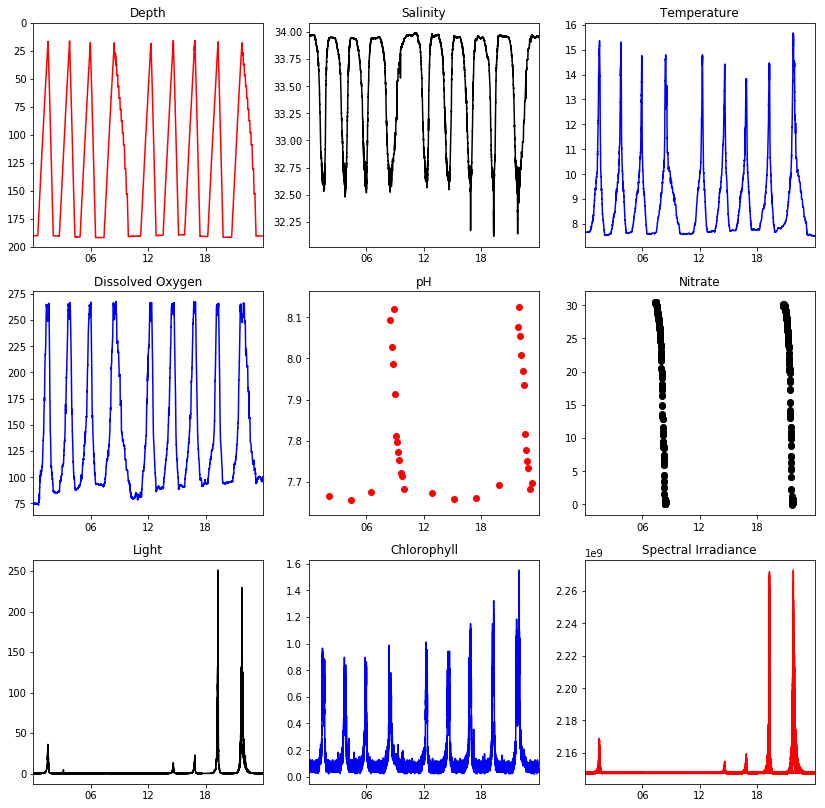

In [8]:
# ctd.seawater_pressure.plot() is a quick check plot provided samples are evenly spaced in time
#   Better: plot each measurement against its time coordinate
n = 9; rn = range(n); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))
a[0,0].plot(ctdF.time, ctdF.seawater_pressure, color='r');                         a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.practical_salinity, color='k');                        a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.seawater_temperature, color='b');                      a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.corrected_dissolved_oxygen, color='b');                a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');                a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, \
        nitrateF.salinity_corrected_nitrate.values, color='k');                    a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                         a[2,0].set(title='Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');            a[2,1].set(title='Chlorophyll')
for i in rsi: a[2,2].plot(siF.time, siF.spkir_samples[:,i], color='r');            a[2,2].set(title='Spectral Irradiance')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)

print('')   # also to hide the ninth chart if there were only 8 to show use: a[-1, -1].axis('off')

### Our story so far

Over a single day we have here eight scalar measurements -- including depth -- as well as *spectral irradiance* 
shown in the ninth chart featuring seven wavelength intensities. This gives a rather
complicated picture of what is happening in the upper 200 meters of the water column in the course of a single day.
Here are a few observations, one for each plot...

- depth profiles number 4 and 9 seem to have taken longer; with stops along the way back down
- profiles 7, 8 and 9 show less salty water near the surface
- the water is consistently about 8 degrees C warmer at the surface than it is at 200 meters depth
  - glodap and argo comparisons go here 
- there is more dissolved oxygen in the surface water compared to at-depth
- surface water is more alkaline
- surface water has a higher concentration of nitrates
- night seems to fall from hours 5 to 14 but this is in fact 10pm to 5am local time
- chlorophyll concentration seems to increase over the course of the daylight hours
- spectral irradiance follows the same pattern as light

Where next? It is common to consider how depth associates with the other measurements (temperature, chlorophyll etcetera)
so let's do that next. But notice this important detail: A temperature-versus-depth chart for the entire day would 
hide the fact that over the course of that day the profiler made nine separate passes through the water column from 
200 meters to near the surface and back again. We will show the data with emphasis on a particular profile selected
using a slider control. 

In [32]:
profdt = [
    (dt64('2017-08-21T00:27:30'),dt64('2017-08-21T02:05:00')),
    (dt64('2017-08-21T02:42:30'),dt64('2017-08-21T04:19:50')),
    (dt64('2017-08-21T04:52:30'),dt64('2017-08-21T06:29:50')),
    (dt64('2017-08-21T07:22:30'),dt64('2017-08-21T09:55:40')),
    (dt64('2017-08-21T11:12:40'),dt64('2017-08-21T12:49:50')),
    (dt64('2017-08-21T13:32:35'),dt64('2017-08-21T15:09:42')),
    (dt64('2017-08-21T15:47:30'),dt64('2017-08-21T17:25:00')),
    (dt64('2017-08-21T18:12:30'),dt64('2017-08-21T19:49:50')),
    (dt64('2017-08-21T20:42:30'),dt64('2017-08-21T23:16:00'))
]

depth=ctdF.seawater_pressure.to_dataset(name='depth')
depth.coords['time'] = ('time', depth.time)
depth['depth'] = (('time'), depth.depth)
depth=depth.drop('obs').drop('lat').drop('lon').drop('seawater_pressure')
depth.depth.attrs['low_value'] = 200.
depth.depth.attrs['high_value'] = 0.

salinity=ctdF.practical_salinity.to_dataset(name='salinity')
salinity.coords['time'] = ('time', salinity.time)
salinity['salinity'] = (('time'), salinity.salinity)
salinity=salinity.drop('obs').drop('lat').drop('lon').drop('seawater_pressure')
salinity.salinity.attrs['low_value'] = 32.
salinity.salinity.attrs['high_value'] = 34.

temperature=ctdF.seawater_temperature.to_dataset(name='temperature')
temperature.coords['time'] = ('time', temperature.time)
temperature['temperature'] = (('time'), temperature.temperature)
temperature=temperature.drop('obs').drop('lat').drop('lon').drop('seawater_pressure')
temperature.temperature.attrs['low_value'] = 7.
temperature.temperature.attrs['high_value'] = 16.

DO=ctdF.corrected_dissolved_oxygen.to_dataset(name='DO')
DO.coords['time'] = ('time', DO.time)
DO['DO'] = (('time'), DO.DO)
DO=DO.drop('obs').drop('lat').drop('lon').drop('seawater_pressure')
DO.DO.attrs['low_value'] = 70.
DO.DO.attrs['high_value'] = 280.

# The Datasets built above are from single DataArrays where the principle coordinate/dimension 
#   has been modified to be time (from observation index 'obs'). These Data variables are 
#   synchronized with depth as they are all produced by the same instrument (the CTD). 
# In what follows the remaining measurements ( pH, nitrate, par, fluor, si ) will require
#   their own depth Data variables; synchronized in time. These values are provided in the
#   source data files via interpolation but I discarded them for the sake of learning how to
#   do this myself. It is generally not the case that this is 'already done for you' as it 
#   is in this instance.
# Some of the subsequent Datasets are further extended by pulling (salinity, temp, DO) values
#   from the CTD. 

pH=phF.ph_seawater.to_dataset(name='pH')
pH.coords['time'] = ('time', pH.time)
pH['pH'] = (('time'), pH.pH)
pH=pH.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
pH['depth']=('time', depth.depth.sel(time=pH.time, method='nearest'))
pH.pH.attrs['low_value'] = 7.6
pH.pH.attrs['high_value'] = 8.2

nitrate=nitrateF.salinity_corrected_nitrate.to_dataset(name='nitrate')
nitrate.coords['time'] = ('time', nitrate.time)
nitrate['nitrate'] = (('time'), nitrate.nitrate)
nitrate=nitrate.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
nitrate['depth']=('time', depth.depth.sel(time=nitrate.time, method='nearest'))
nitrate['salinity']=('time', salinity.salinity.sel(time=nitrate.time, method='nearest'))
nitrate['temperature']=('time', temperature.temperature.sel(time=nitrate.time, method='nearest'))
nitrate['DO']=('time', DO.DO.sel(time=nitrate.time, method='nearest'))
nitrate.nitrate.attrs['low_value'] = 0.
nitrate.nitrate.attrs['high_value'] = 32.
nitrate.depth.attrs['low_value'] = depth.depth.attrs['low_value']
nitrate.depth.attrs['high_value'] = depth.depth.attrs['high_value']
nitrate.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
nitrate.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
nitrate.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
nitrate.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
nitrate.DO.attrs['low_value'] = DO.DO.attrs['low_value']
nitrate.DO.attrs['high_value'] = DO.DO.attrs['high_value']

par=parF.par_counts_output.to_dataset(name='par')
par.coords['time'] = ('time', par.time)
par['par'] = (('time'), par.par)
par=par.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
par['depth']=('time', depth.depth.sel(time=par.time, method='nearest'))
par['salinity']=('time', salinity.salinity.sel(time=par.time, method='nearest'))
par['temperature']=('time', temperature.temperature.sel(time=par.time, method='nearest'))
par['DO']=('time', DO.DO.sel(time=par.time, method='nearest'))
par.par.attrs['low_value'] = 0.
par.par.attrs['high_value'] = 250.
par.depth.attrs['low_value'] = depth.depth.attrs['low_value']
par.depth.attrs['high_value'] = depth.depth.attrs['high_value']
par.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
par.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
par.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
par.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
par.DO.attrs['low_value'] = DO.DO.attrs['low_value']
par.DO.attrs['high_value'] = DO.DO.attrs['high_value']

fluor=fluorF.fluorometric_chlorophyll_a.to_dataset(name='fluor')
fluor.coords['time'] = ('time', fluor.time)
fluor['fluor'] = (('time'), fluor.fluor)
fluor=fluor.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')
fluor['depth']=('time', depth.depth.sel(time=fluor.time, method='nearest'))
fluor['salinity']=('time', salinity.salinity.sel(time=fluor.time, method='nearest'))
fluor['temperature']=('time', temperature.temperature.sel(time=fluor.time, method='nearest'))
fluor['DO']=('time', DO.DO.sel(time=fluor.time, method='nearest'))
fluor.fluor.attrs['low_value'] = 0.0
fluor.fluor.attrs['high_value'] = 1.6
fluor.depth.attrs['low_value'] = depth.depth.attrs['low_value']
fluor.depth.attrs['high_value'] = depth.depth.attrs['high_value']
fluor.temperature.attrs['low_value'] = temperature.temperature.attrs['low_value']
fluor.temperature.attrs['high_value'] = temperature.temperature.attrs['high_value']
fluor.salinity.attrs['low_value'] = salinity.salinity.attrs['low_value']
fluor.salinity.attrs['high_value'] = salinity.salinity.attrs['high_value']
fluor.DO.attrs['low_value'] = DO.DO.attrs['low_value']
fluor.DO.attrs['high_value'] = DO.DO.attrs['high_value']

si=siF.spkir_samples.to_dataset(name='si')
si.coords['time'] = ('time', si.time)
si.coords['spectra'] = ('spectra', si.spectra)
si['si'] = (('time', 'spectra'), si.si)
si=si.drop('obs').drop('lat').drop('lon').drop('int_ctd_pressure')

In [22]:
colorize = ['red', 'orange', 'yellow', 'green', 'lightgreen', 'cyan', 'blue', 'magenta', 'black']

argo_d = g.SetDataDirectory('ooi/argo')
argo2 = xr.open_dataset(argo_d + 'profile2.nc')
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)

def VDC(da, z, profile_index, xlabel):       # Versus-Depth Chart
    fig,axes = plt.subplots()
    fig.set_size_inches(13,9)
    axes.set(xlim=(da.low_value, da.high_value), ylim=(200., 0.), xlabel=xlabel, ylabel='Depth (meters)')
    for i in range(9):
        if i != profile_index: 
            tmp   = da.where(da.time > profdt[i][0], drop = True)
            tmp1  = tmp.where(tmp.time < profdt[i][1], drop = True)
            dtmp  = z.where(z.time >  profdt[i][0], drop = True)
            dtmp1 = dtmp.where(dtmp.time < profdt[i][1], drop = True)
            # print(tmp1, '\n\n\n', dtmp1)
            axes.plot(tmp1, dtmp1, ',', color=colorize[i])   # ',' gives small markers
    # Now the selected profile prints on top with larger markers
    tmp   = da.where(da.time > profdt[profile_index][0], drop = True)
    tmp1  = tmp.where(tmp.time < profdt[profile_index][1], drop = True)
    dtmp  = z.where(z.time >  profdt[profile_index][0], drop = True)
    dtmp1 = dtmp.where(dtmp.time < profdt[profile_index][1], drop = True)       
    axes.plot(tmp1, dtmp1, '.', color = colorize[profile_index])    # '.' larger markers
    axes.plot(a2psu.psu.values, a2psu.depth.values, 'o-', color='black')


def PlotConfigure(X_choice, profile_choice):
    profIdx = profile_choice - 1
    if   X_choice == 'depth'      : VDC(depth.depth, depth.depth, profIdx, 'depth (meters)')
    elif X_choice == 'temperature': VDC(temperature.temperature, depth.depth, profIdx, 'temperature (deg C)')
    elif X_choice == 'salinity'   : VDC(salinity.salinity, depth.depth, profIdx, 'salinity (psu)')
    elif X_choice == 'DO'         : VDC(DO.DO, depth.depth, profIdx, 'dissolved oxygen (ug/l)')
    elif X_choice == 'nitrate'    : VDC(nitrate.nitrate, nitrate.depth, profIdx, 'nitrate')
    elif X_choice == 'pH'         : VDC(pH.pH, pH.depth, profIdx, 'pH')
    elif X_choice == 'PAR'        : VDC(par.par, par.depth, profIdx, 'light (PAR)')
    elif X_choice == 'chlorophyll': VDC(fluor.fluor, fluor.depth, profIdx, 'chlorophyll')
    else                          : VDC(si.si[:,0], si.depth, profIdx, 'spectral irradiance')
        
interact(PlotConfigure, 
         profile_choice=widgets.IntSlider(min = 1, max = 9, step = 1, value = 1, 
                    continuous_update = False, readout_format = 'd', description='profile (1-9)'),
         
         X_choice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO', 
                                               'nitrate', 'pH', 'PAR', 'spectral irradiance', 'chlorophyll'],
                                      value='temperature', description='data type', disabled = False)
        )      

interactive(children=(Select(description='data type', index=1, options=('depth', 'temperature', 'salinity', 'D…

<function __main__.PlotConfigure>

In [35]:
def XvY(x, y, xt, yt, xLbl, yLbl):
    fig,axes = plt.subplots()
    fig.set_size_inches(13,9)
    axes.set(xlim=(x.low_value, x.high_value), ylim=(y.low_value, y.high_value), xlabel=xLbl, ylabel=yLbl)
    
    # par['depth']=('time', depth.depth.sel(time=par.time, method='nearest'))

    for i in range(9):
        xtmp = x.where(xt > profdt[i][0], drop=True)
        xtmp1 = xtmp.where(xtmp.time < profdt[i][1], drop=True).values
        ytmp  = y.where(yt > profdt[i][0], drop=True)
        ytmp1  = ytmp.where(ytmp.time < profdt[i][1], drop=True).values
        axes.plot(xtmp1, ytmp1, ',', color=colorlist[i]) 
        
def Caller(xChoice, yChoice):
    if xChoice == 'depth':       x = depth.depth;             xt = depth.time;       xs = 'depth (m)'
    if xChoice == 'temperature': x = temperature.temperature; xt = temperature.time; xs = 'temp (C)'
    if xChoice == 'salinity':    x = salinity.salinity;       xt = salinity.time;    xs = 'salinity (psu)'
    if xChoice == 'DO':          x = DO.DO;                   xt = DO.time;          xs = 'DO (ug/l)'
        
    if yChoice == 'depth':       y = depth.depth;             yt = depth.time;       ys = 'depth (m)'
    if yChoice == 'temperature': y = temperature.temperature; yt = temperature.time; ys = 'temp (C)'
    if yChoice == 'salinity':    y = salinity.salinity;       yt = salinity.time;    ys = 'salinity (psu)'
    if yChoice == 'DO':          y = DO.DO;                   yt = DO.time;          ys = 'DO (ug/l)'

    if yChoice == 'nitrate':     
        y  = nitrate.nitrate        
        yt = nitrate.time   
        ys = 'nitrate'

        if xChoice == 'depth':       x = nitrate.depth;       xt = nitrate.time; xs = 'depth (m)'
        if xChoice == 'temperature': x = nitrate.temperature; xt = nitrate.time; xs = 'temp (C)'
        if xChoice == 'salinity':    
            x = nitrate.salinity
            xt = nitrate.time; 
            xs = 'salinity (psu)'
        if xChoice == 'DO':          x = nitrate.DO;          xt = nitrate.time; xs = 'DO (ug/l)'
        
    if yChoice == 'PAR':         
        y  = par.par                 
        yt = par.time         
        ys = 'PAR'

        if xChoice == 'depth':       x = par.depth;       xt = par.time; xs = 'depth (m)'
        if xChoice == 'temperature': x = par.temperature; xt = par.time; xs = 'temp (C)'
        if xChoice == 'salinity':    x = par.salinity;    xt = par.time; xs = 'salinity (psu)'
        if xChoice == 'DO':          x = par.DO;          xt = par.time; xs = 'DO (ug/l)'
        
    if yChoice == 'chlor': 
        y  = fluor.fluor             
        yt = fluor.time       
        ys = 'chlor'
        if xChoice == 'depth':       x = fluor.depth;       xt = fluor.time; xs = 'depth (m)'
        if xChoice == 'temperature': x = fluor.temperature; xt = fluor.time; xs = 'temp (C)'
        if xChoice == 'salinity':    x = fluor.salinity;    xt = fluor.time; xs = 'salinity (psu)'
        if xChoice == 'DO':          x = fluor.DO;          xt = fluor.time; xs = 'DO (ug/l)'

    XvY(x, y, xt, yt, xs, ys)

interact(Caller, 
         xChoice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO'],
                                           value='salinity', description='X axis', disabled = False),
         yChoice = widgets.Select(options=['depth', 'temperature', 'salinity', 'DO', 'nitrate', 'PAR', 'chlor'],
                                           value='temperature', description='Y axis', disabled = False))

interactive(children=(Select(description='X axis', index=2, options=('depth', 'temperature', 'salinity', 'DO')…

<function __main__.Caller>

In [ ]:
fig,axes = plt.subplots()
fig.set_size_inches(10,10)
axes.invert_yaxis()
axes.set(xlim=(32.0, 34.), ylim=(70., 280.), xlabel='Salinity (psu)', ylabel='Dissolved Oxygen (ug / liter)')
for i in range(9):
    psu3 = psu2.psu_hours.where(psu2.hours > tbds[i], drop=True)
    psu4 = psu3.where(psu3.hours < tbds[i+1], drop=True).values
    DO3  = DO2.DO_hours.where(DO2.hours > tbds[i], drop=True)
    DO4  = DO3.where(DO3.hours < tbds[i+1], drop=True).values
    axes.plot(psu4, DO4, ',', color = colorlist[i]) 

In [ ]:
fig,axes = plt.subplots()
fig.set_size_inches(10,10)
axes.invert_yaxis()
axes.set(xlim=(7.0, 16.), ylim=(70., 280.), xlabel='Temperature (deg C)', ylabel='Dissolved Oxygen (ug / liter)')
for i in range(9):
    temperature3 = temperature2.temperature_hours.where(temperature2.hours > tbds[i], drop=True)
    temperature4 = temperature3.where(temperature3.hours < tbds[i+1], drop=True).values
    DO3  = DO2.DO_hours.where(DO2.hours > tbds[i], drop=True)
    DO4  = DO3.where(DO3.hours < tbds[i+1], drop=True).values
    axes.plot(temperature4, DO4, ',', color=colorlist[i]) 

In [ ]:
d.practical_salinity.plot() # This shows the tail data in the last three profiles

The following line magic harmonizes 3D figures with the Jupyter notebook.

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO5, temperature5, psu5, c=depth5)
axes.view_init(60, -30)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
fig.show()

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO5, temperature5, psu5, c=depth5)
axes.view_init(30, -60)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
fig.show()

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(11,11))
axes = fig.gca(projection='3d')      # ...or axes = fig.add_subplot(111, projection='3d')
scatter = axes.scatter(DO5, temperature5, psu5, c=depth5)
axes.view_init(10, -90)             # 30, -60 (and dist = 10) are the defaults (use axes.azim, .elev, .dist)
axes.set_xlabel("DO (umol/Liter)")
axes.set_ylabel("Temperature (deg C)")
axes.set_zlabel("Salinity (psu)")
fig.colorbar(scatter)
fig.show()

In [ ]:
# help(axes.view_init)
# g.dirnou(axes)
# axes.azim
print(axes.azim, axes.elev, axes.dist)

### including ARGO drifter data

In [ ]:
# !wget ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20190320_035619_7746409.tgz

In [13]:
argo_d = g.SetDataDirectory('ooi/argo')
argo1 = xr.open_dataset(argo_d + 'profile1.nc')
argo2 = xr.open_dataset(argo_d + 'profile2.nc')
argo2

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_HISTORY: 4, N_LEVELS: 70, N_PARAM: 3, N_PROF: 2)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object ...
    PROJECT_NAME                  (N_PROF) object ...
    PI_NAME                       (N_PROF) object ...
    STATION_PARAMETERS            (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                  (N_PROF) float64 ...
    DIRECTION                     (N_PROF) object ...
    DATA_CENTRE                   (N_PROF) object ...
    DC_REFERENCE                  (N_PROF) object ...
    DATA_STATE_INDICATOR          (N_PROF) object ...
    DATA_MODE            

In [14]:
print(argo1.LATITUDE[0], argo1.LONGITUDE[0])
print(argo2.LATITUDE[0], argo2.LONGITUDE[0], argo2.LATITUDE[1], argo2.LONGITUDE[1])

<xarray.DataArray 'LATITUDE' ()>
array(44.136)
Attributes:
    long_name:      Latitude of the station, best estimate
    standard_name:  latitude
    units:          degree_north
    valid_min:      -90.0
    valid_max:      90.0
    axis:           Y <xarray.DataArray 'LONGITUDE' ()>
array(-127.704)
Attributes:
    long_name:      Longitude of the station, best estimate
    standard_name:  longitude
    units:          degree_east
    valid_min:      -180.0
    valid_max:      180.0
    axis:           X
<xarray.DataArray 'LATITUDE' ()>
array(43.6)
Attributes:
    long_name:      Latitude of the station, best estimate
    standard_name:  latitude
    units:          degree_north
    valid_min:      -90.0
    valid_max:      90.0
    axis:           Y <xarray.DataArray 'LONGITUDE' ()>
array(-127.192)
Attributes:
    long_name:      Longitude of the station, best estimate
    standard_name:  longitude
    units:          degree_east
    valid_min:      -180.0
    valid_max:      180.0


In [15]:
print(argo1.JULD)
print(argo2.TEMP_ADJUSTED[0])
print(argo2.PRES_ADJUSTED[0])

<xarray.DataArray 'JULD' (N_PROF: 1)>
array(['2017-08-23T05:24:46.000000000'], dtype='datetime64[ns]')
Dimensions without coordinates: N_PROF
Attributes:
    long_name:      Julian day (UTC) of the station relative to REFERENCE_DAT...
    standard_name:  time
    conventions:    Relative julian days with decimal part (as parts of day)
    axis:           T
<xarray.DataArray 'TEMP_ADJUSTED' (N_LEVELS: 70)>
array([16.062, 15.978, 15.835, 12.84 , 11.611, 12.009, 10.301, 11.018, 10.565,
        9.725,  9.484,  9.03 ,  8.705,  8.436,  8.341,  8.135,  7.978,  7.779,
        7.636,  7.521,  7.372,  7.32 ,  7.262,  7.131,  7.083,  7.056,  6.992,
        6.945,  6.844,  6.66 ,  6.585,  6.503,  6.399,  6.339,  6.325,  6.306,
        6.007,  5.699,  5.774,  5.699,  5.065,  4.798,  4.615,  4.5  ,  4.483,
        4.325,  4.195,  4.049,  3.935,  3.809,  3.696,  3.539,  3.355,  3.265,
        3.119,  3.047,  2.979,  2.901,  2.762,  2.661,  2.589,  2.523,  2.451,
        2.366,  2.296,  2.2  ,  2.14 ,

In [16]:
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)
a2psu

<xarray.Dataset>
Dimensions:  (depth: 70)
Coordinates:
  * depth    (depth) float32 6.1 10.6 19.8 30.5 ... 1800.1 1850.3 1899.5 1950.1
Data variables:
    psu      (depth) float32 32.2636 32.28154 32.31345 ... 34.58297 34.58093

[(200.0, 0.0), (32.0, 34.0)]

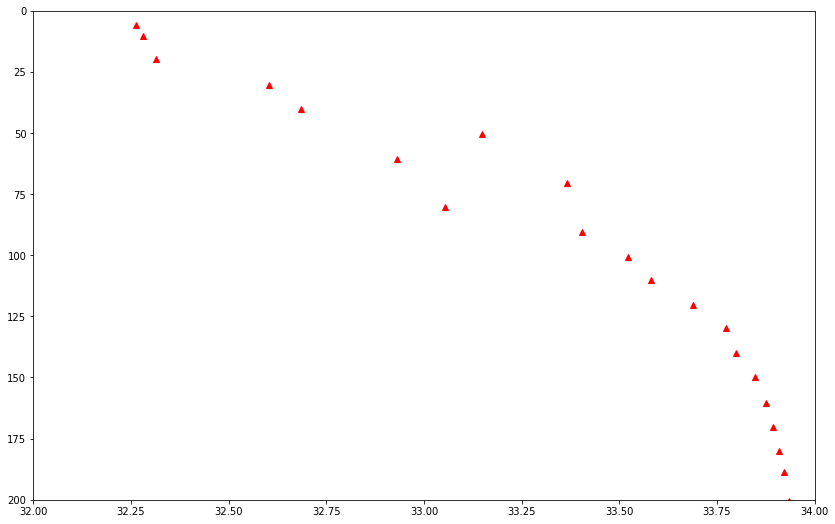

In [89]:
argo_d = g.SetDataDirectory('ooi/argo')
argo1 = xr.open_dataset(argo_d + 'profile1.nc')
argo2 = xr.open_dataset(argo_d + 'profile2.nc')
a2psu=argo2.PSAL_ADJUSTED[0].to_dataset(name='psu')
a2psu.coords['depth'] = ('depth', argo2.PRES_ADJUSTED[0])
a2psu['psu'] = (('depth'), a2psu.psu)
f,a = plt.subplots()
f.set_size_inches(14,9)
a.plot(a2psu.psu.values, a2psu.depth.values, '^', color='red')
a.set(ylim=(200.,0.), xlim=(32.,34.))

### Cross-instrument synchrony


Here we describe a fairly simple task and its resolution using `xarray` DataArrays and Datasets: You have 
two sensors recording time series data, each with its own clock and hence its own timestamps. Let's
suppose these are *nitrate* and *depth* measured by independent sensors on the same physical structure, 
a pod that is periodically raised and lowered through the water column. This will be followed by a second
example where we will compare data from two independent profilers. 


#### Case 1: Single profiler with CTD and Nitrate sensors


A profiler rises and descends slowly through the upper 200 meters of the ocean water column nine times each
day. Two of these nine profiles (at local noon and midnight) activate an onboard nitrate sensor with its own clock.
On obtaining data for a single day we find that these two nitrate profiles generate a total of 429 observations.
These are indexed using an `obs` integer value `0, 1, ..., 428`. The `xarray Dataset` representation presents
`time` as a coordinate associated with the `obs` dimension and `nitrate` as a Data variable also associated with
the `obs` dimension. (For completeness the dataset (NetCDF file) is provided with depth data already built in
but we ignore this for the sake of the exercise.) 


A CTD sensor on the same profiler platform with its own clock is measuring `depth` every second. The corresponding
dataset is missing three observations in the course of the same day; so there are a total of 86,397 observations
in the CTD `Dataset` including `depth`. I am using simplified parameter names here by the way. 


Here is the problem: Make a scatter plot of the two nitrate profiles taken on this day as a function of depth. Again 
this is working from two files `nitrate.nc` and `depth.nc` transferred to two corresponding `xarray Datasets` called
`nitrate` and `depth`; with respectively 429 nitrate values and 86,397 CTD depth values. Both Datasets have
dimensions `obs` connected to both a `time` coordinate and a `nitrate` / `depth` Data variable. 


The method is to match nitrate value to depth by means of nearest time. This will reconcile the two independent
clocks. We do this by building a `list` of 429 `time` values as `time_list[]` and then using the `xarray` select method
`.sel(time=time_list, method='nearest')`. This might be possible using the `obs` dimension but the method presented
here first creates a *new* dimension of `time` which is linked to a dimension of the same name. That is: 
An `xarray Dataset coordinate` can be linked to a `dimension` of the same name or not. Initially our `time` 
coordinate is linked to the `obs` dimension which creates an unhelpful level of abstraction: The `obs` sequence of 
one Dataset is not comparable to the `obs` sequence of the other by observation number. It is `time` that is the 
comparable quantity; so operating from a 'simple tools' perspective we first create the `time dimension` linked 
to the `time coordinate` and carry on from there. 


There are some key ideas to emphasize in carrying out this procedure. 


- `.sel()` selects on dimensions (not coordinates) whereas our goal is to select based on coordinate (`time`) values.
We resolve this problem by creating a `time` dimension linked to the `time` coordinate.
- The `time_list[]` assigned to `time` in the `.sel` method could be generated by *any* means. It must simply be a list
of time values of the correct type (datetime64). 
- The `.sel()` selection method pulls out a `DataArray` from a named `Data variable` (in this case `depth`) but it 
also brings along corresponding `coordinate/dimension` values (the `datetime64` time values. These should be 
comparable to their source values found in the `nitrate` Dataset.
- This operation makes use of the idea that a `Dataset` may contain multiple `Data Arrays` that are independent
of one another. Here the `depth Dataset` has a `Data variable` called `depth` which has 86397 values. We want
to create a *new* `Data variable` called (say) `depth_for_nitrate` that has 429 values. This can be done either 
within the existing `Dataset` or as a new `Dataset` or as a new `DataArray`. 


<xarray.Dataset>
Dimensions:  (time: 86397, time1: 429)
Coordinates:
  * time     (time) datetime64[ns] 2017-08-21T00:00:00.803386368 ... 2017-08-21T23:59:59.015734272
  * time1    (time1) datetime64[ns] 2017-08-21T07:22:21.166164480 ... 2017-08-21T21:46:56.991324672
Data variables:
    depth    (time) float64 190.3 190.3 190.3 190.3 ... 190.5 190.5 190.5 190.5
    nitrate  (time1) float64 30.41 30.44 30.55 30.37 ... 0.6578 0.7092 0.6619
Here is the attempt to create a new DataArray da using .sel()

time_selector=d.time1.values.tolist()
da=d['nitrate'].sel(time=time_selector, method='nearest')
and this produces the Value Error as given in the Issue subject; and in full detail below.

Q1: What is going on here?
Bonus Q2: How does one learn xarray so as to not run aground in this manner?

Error message:

```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-215-2cb483f8a1ab> in <module>()
----> 1 da=d['nitrate'].sel(time=time_selector, method='nearest')

[redacted details]

ValueError: dimensions or multi-index levels ['time'] do not exist
```

Ryan responds: 


The error tells us that time is not a dimension of nitrate; its dimension is time1 per the output.

Data variables:
    depth    (time) 
    nitrate  (time1)
It would have been more useful if the error message also said, "possible dimensions are: time1". I believe your example would work if you had done

da=d.nitrate.sel(time1=d.time.values, method='nearest')


Also be aware (if in fact you would like to interpolate depth values by time) that `xarray` provides 
the [`interp()` method]( http://xarray.pydata.org/en/stable/interpolation.html).

```
da=d.nitrate.interp(time1=d.time.values)
```


This sort of question belongs on Stack Overflow or the `xarray` issue tracker: To produce a permanent, 
searchable public record. But online discussions often break down because the next step is often either 
a) you try to share your data with me or b) someone asks you convert your actual problem into a copy-pasteable 
simplified example with synthetic data. Neither is very easy or welcoming to an `xarray` Learner.

**With Pangeo we have an opportunity to solve this techincal problem because we can potentially both have access 
to the exact same environment and the exact same data via the cloud. So you could cut and paste your actual code 
from your environment and I could just run it immediately. What if we had a chat window right in a Jupyterlab on 
a shared cluster where people could just post questions and talk about data and code?**

The harder question is how to provide a general education on using pangeo-related tools? Ideally this would
be a dedicated (grant supported) position. Matt Rocklin's 
[blog post on Public Institutions and Open Source Software](https://matthewrocklin.com/blog//work/2018/08/21/institutional-open-source) is pretty insightful on this topic. 
Big institutions and universities can devote resources to supporting their own tools; but in contrast nobody 
'owns' xarray, so it carries no education mandate. It has just propagated organically and unevenly. 
If big institutions could pivot to supporting an open source ecosystem more broadly it would be good for everyone.



Rob: 


My concern for the learner is that Python packages like `xarray` can obscure their own functionality for 
good aesthetic reasons. An `xarray Dataset` has 110 attributes before you put any data in it, for example.
That's a lot to comprehend; so it can be a frustrating learning experience. Stack overflow is more of a solution
resource than a learning resource. It teaches me to craft carefully worded search strings to find an existing 
issue/solution; wherein I hope to find the line of code in the green checkbox reply that gets me on my way. 
This does not necessarily enhance my context web; so the risk is that my context web becomes a collection of 
magical spells.